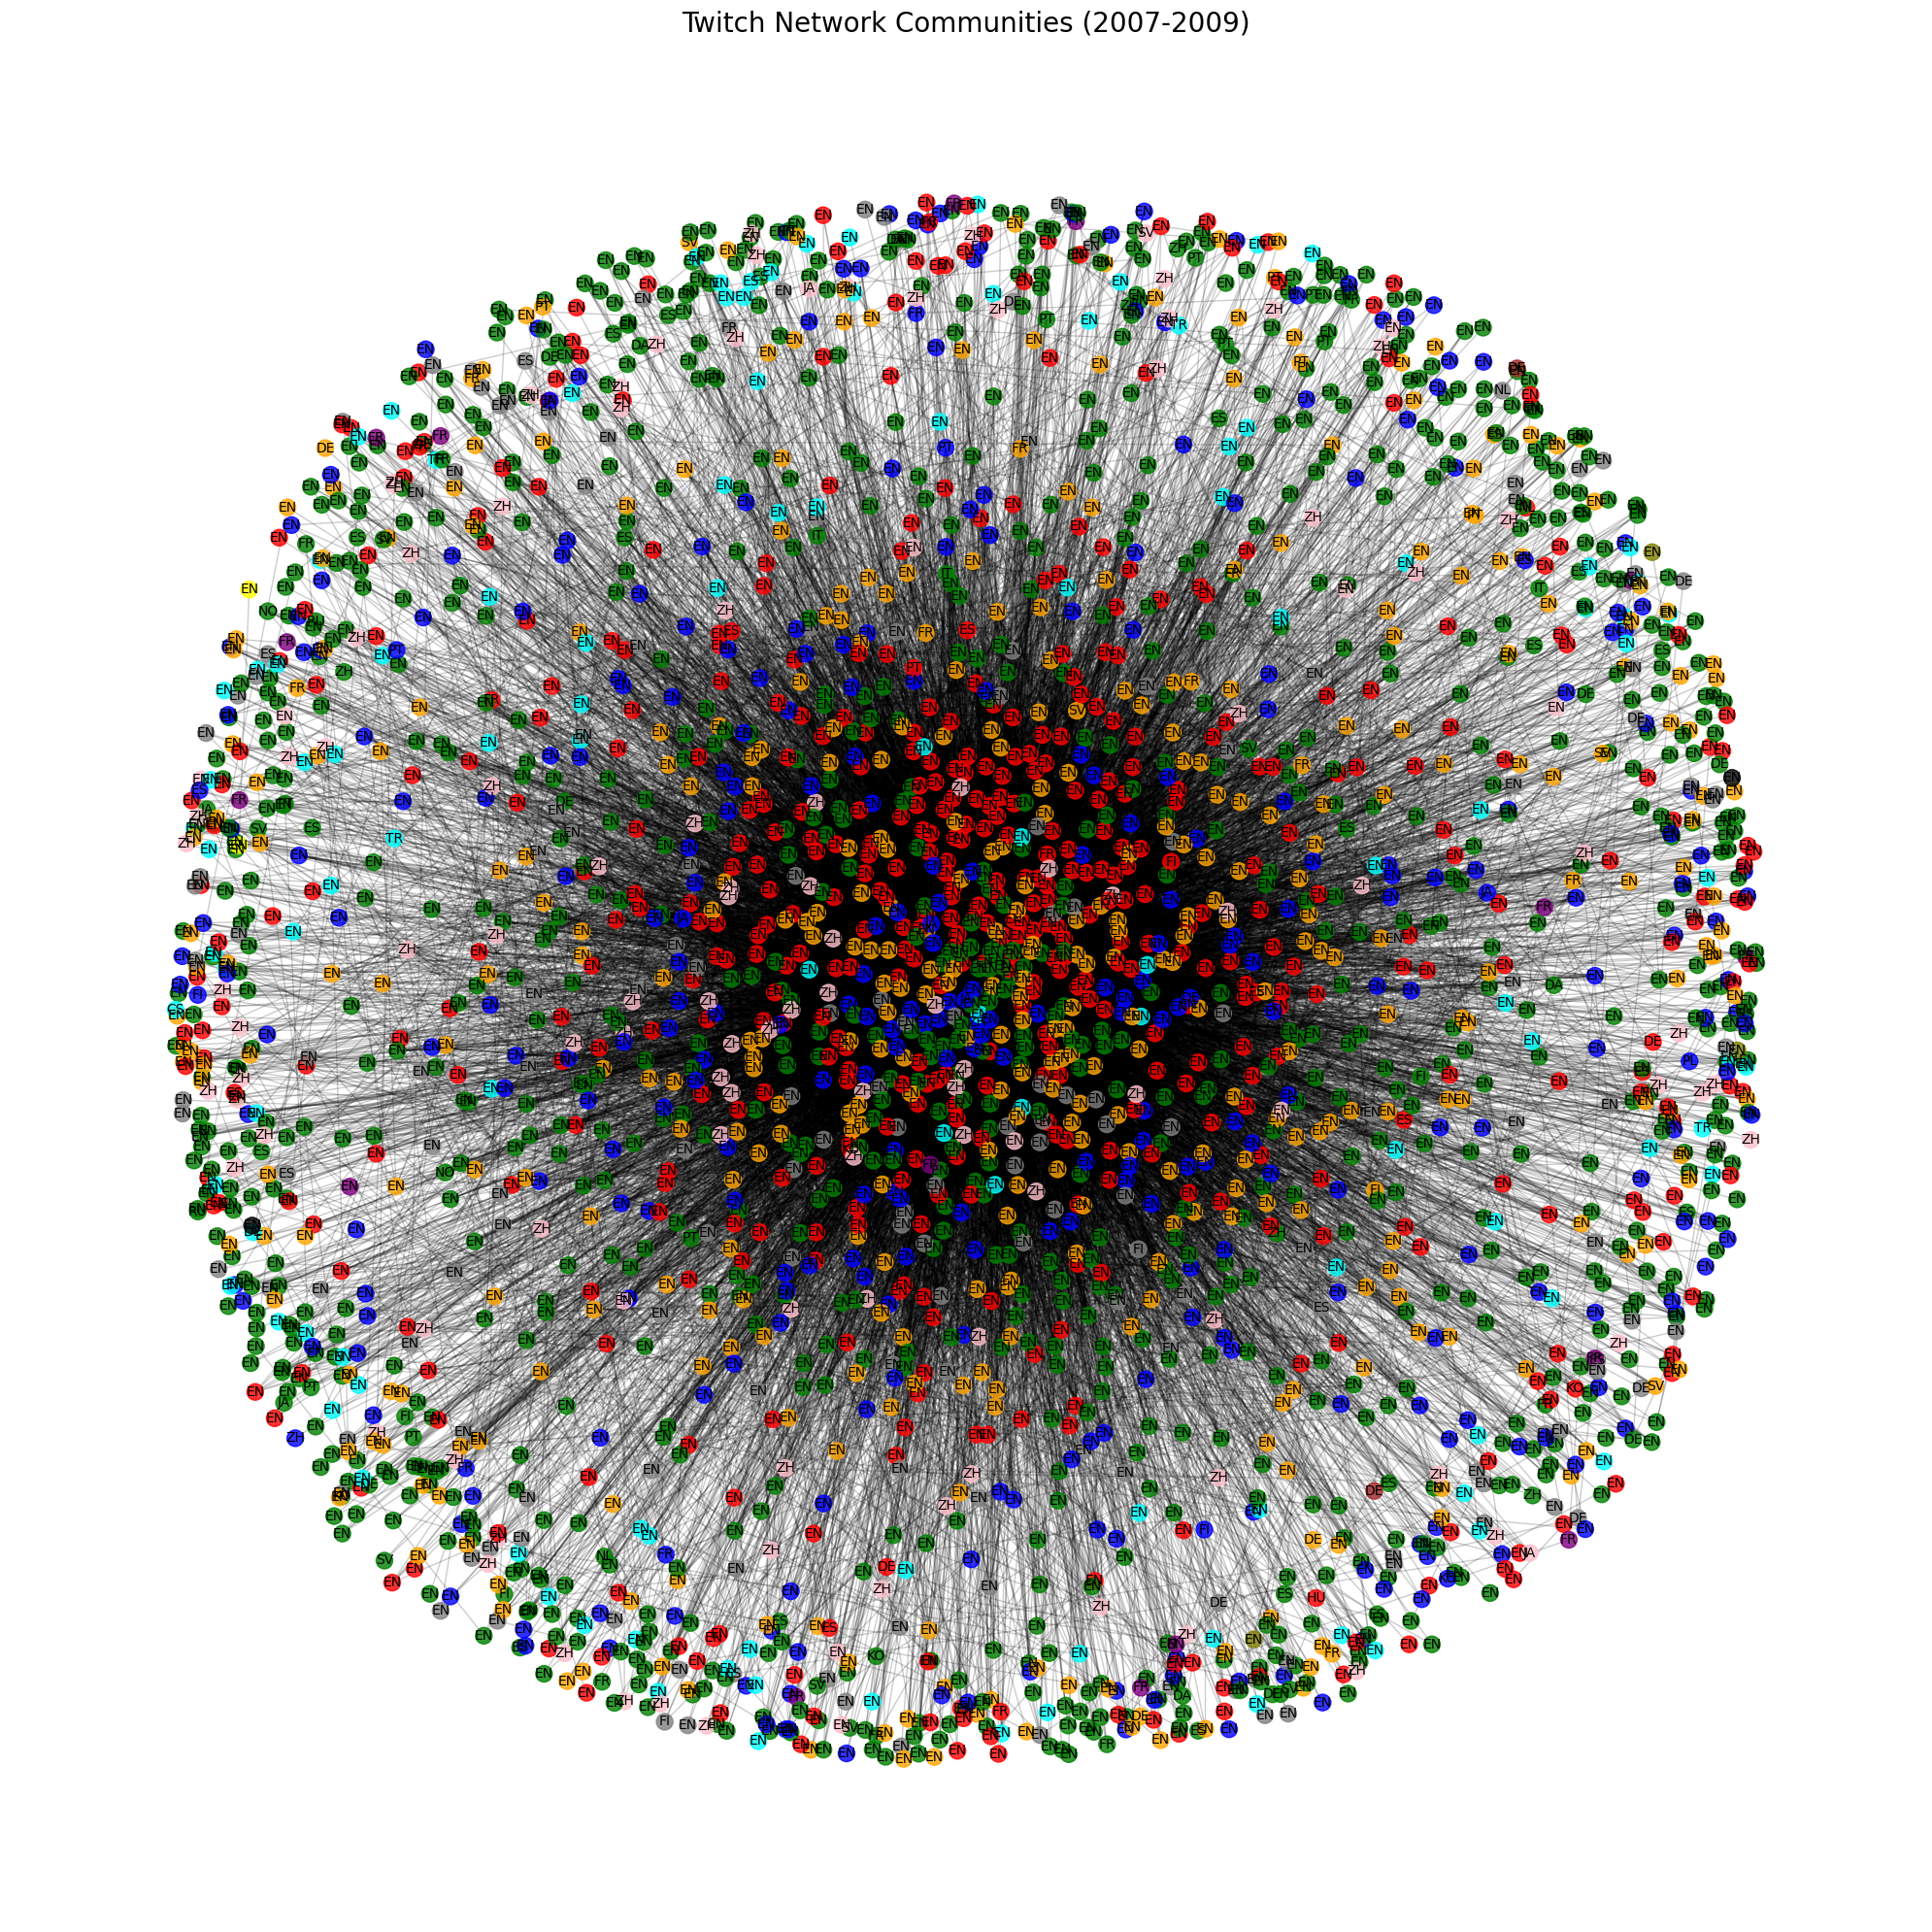

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain

# Load the streamer data
twitchDf = pd.read_csv('large_twitch_features.csv')

# Remove rows where the language is "OTHER" or dead_account is 1
twitchDf = twitchDf[(twitchDf['language'] != 'OTHER') & (twitchDf['dead_account'] != 1)]

# Drop the 'updated_at' column
twitchDf = twitchDf.drop(columns=['updated_at'], errors='ignore')

# Load the friendships data
edges = pd.read_csv('large_twitch_edges.csv')

# Ensure the 'created_at' column is in datetime format
twitchDf['created_at'] = pd.to_datetime(twitchDf['created_at'])

# Filter rows for the years 2007 to 2009
twitchDf_2007_2009 = twitchDf[(twitchDf['created_at'].dt.year >= 2007) & (twitchDf['created_at'].dt.year <= 2009)]

# Extract the 'numeric_id' values from the filtered DataFrame
numeric_ids_2007_2009 = twitchDf_2007_2009['numeric_id'].unique()

# Filter the friendships DataFrame to include only rows where both numeric_id_1 and numeric_id_2 are in numeric_ids_2007_2009
filtered_edges = edges[
  (edges['numeric_id_1'].isin(numeric_ids_2007_2009)) & 
  (edges['numeric_id_2'].isin(numeric_ids_2007_2009))
]

# Create a NetworkX graph
G = nx.Graph()

# Add edges to the graph
edges_list = list(zip(filtered_edges['numeric_id_1'], filtered_edges['numeric_id_2']))
G.add_edges_from(edges_list)

# Perform community detection using the Louvain method
partition = community_louvain.best_partition(G)

# Get a list of unique communities and their sizes
communities = set(partition.values())
community_sizes = {community: sum(1 for node in partition.values() if node == community) for community in communities}

# Define a list of colors
color_names = ['red', 'blue', 'green', 'purple', 'orange', 'pink', 'brown', 'grey', 'olive', 'cyan', 'black', 'yellow']
color_map = {community: color_names[i % len(color_names)] for i, community in enumerate(communities)}

# Assign colors to nodes based on their community
node_colors = [color_map[partition[node]] for node in G.nodes()]

# Get language labels for nodes
language_map = twitchDf.set_index('numeric_id')['language'].to_dict()

# Layout for organized communities with minimal overlap (using Spring Layout)
pos = nx.spring_layout(G, k=0.4)  # Adjust k for node spacing (lower k for tighter layout)

# Plot the graph
plt.figure(figsize=(20, 20))

# Draw nodes with community colors and reduce node size
nx.draw_networkx_nodes(G, pos, node_size=150, node_color=node_colors, alpha=0.8)

# Draw edges with reduced opacity
nx.draw_networkx_edges(G, pos, alpha=0.2)

# Draw labels inside the nodes with the language
labels = {node: language_map.get(node, '') for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color='black')

# Show plot
plt.title('Twitch Network Communities (2007-2009)', fontsize=20)
plt.axis('off')  # Remove unnecessary axes
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

# Calculate total views per community and views per size
community_views = {}
community_views_per_size = {}

# Initialize reordered_community_views dictionary
reordered_community_views = {}

# First, sort communities by size in descending order and create a new order
sorted_communities_by_size = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)
community_order = {community: i for i, (community, _) in enumerate(sorted_communities_by_size)}

# Reassign community numbers based on the new order
reordered_partition = {node: community_order[partition[node]] for node in partition}
reordered_communities = set(reordered_partition.values())
reordered_community_sizes = {community: sum(1 for node in reordered_partition.values() if node == community) for community in reordered_communities}

# Calculate total views and views per size for reordered communities
max_views_per_size = 0
for community in reordered_communities:
    community_nodes = [node for node in G.nodes() if reordered_partition[node] == community]
    community_df = twitchDf[twitchDf['numeric_id'].isin(community_nodes)]
    total_views = community_df['views'].sum()
    reordered_community_views[community] = total_views
    views_per_size = total_views / reordered_community_sizes[community]
    community_views_per_size[community] = views_per_size
    if views_per_size > max_views_per_size:
        max_views_per_size = views_per_size

# Normalize the views per size to be between 1 and 100
for community in reordered_communities:
    community_views_per_size[community] = (community_views_per_size[community] / max_views_per_size) * 100

# Calculate centrality metrics
betweenness_centrality = nx.betweenness_centrality(G)
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

# Print summary of community features
summary_lines = []
for community in sorted_communities_by_size:
    community_index = community_order[community[0]]
    community_nodes = [node for node in G.nodes() if reordered_partition[node] == community_index]
    community_df = twitchDf[twitchDf['numeric_id'].isin(community_nodes)]
    
    community_size = reordered_community_sizes[community_index]
    languages = community_df['language'].value_counts().to_dict()
    affiliates = community_df['affiliate'].sum()
    mature = community_df['mature'].sum()
    views = reordered_community_views[community_index]
    average_lifetime = community_df['life_time'].mean()
    dead_accounts = community_df['dead_account'].sum()
    views_per_size = community_views_per_size[community_index]
    
    # Calculate additional community metrics
    density = nx.density(G.subgraph(community_nodes))
    average_degree = sum(dict(G.degree(community_nodes)).values()) / len(community_nodes)
    
    # Calculate size to mature and affiliate aspects
    mature_ratio = (mature / community_size) if mature != 0 else community_size
    affiliate_ratio = (affiliates / community_size) if affiliates != 0 else community_size
    
    # Calculate average centralities for the community
    avg_betweenness_centrality = sum(betweenness_centrality[node] for node in community_nodes) / len(community_nodes)
    avg_degree_centrality = sum(degree_centrality[node] for node in community_nodes) / len(community_nodes)
    avg_closeness_centrality = sum(closeness_centrality[node] for node in community_nodes) / len(community_nodes)
    
    # Top 5 users by centrality metrics
    top_users = community_df[['numeric_id', 'views', 'life_time', 'affiliate', 'mature', 'language']].copy()
    top_users['betweenness_centrality'] = top_users['numeric_id'].map(betweenness_centrality)
    top_users['degree_centrality'] = top_users['numeric_id'].map(degree_centrality)
    top_users['closeness_centrality'] = top_users['numeric_id'].map(closeness_centrality)
    
    top_users = top_users.sort_values(
        by=['betweenness_centrality', 'degree_centrality', 'closeness_centrality'],
        ascending=False
    ).head(5)
    
    top_users_summary = "\n".join(
        f"User {row['numeric_id']}:\n"
        f"  Betweenness Centrality: {row['betweenness_centrality']:.4f}\n"
        f"  Degree Centrality: {row['degree_centrality']:.4f}\n"
        f"  Closeness Centrality: {row['closeness_centrality']:.4f}\n"
        f"  Views: {row['views']}\n"
        f"  Affiliate: {row['affiliate']}\n"
        f"  Mature Content: {row['mature']}\n"
        f"  Language: {row['language']}\n"
        f"  Lifetime: {row['life_time']}\n"
        for _, row in top_users.iterrows()
    )

    community_color = color_map[community_index]
    summary_lines.append(
        f"Community {community_index} (Color: {community_color}):\n"
        f"Size: {community_size}\n"
        f"Views per Size: {views_per_size:.2f}\n"
        f"Size to Mature Aspect: {mature_ratio:.2f}\n"
        f"Size to Affiliate Aspect: {affiliate_ratio:.2f}\n"
        f"Density: {density:.2f}\n"
        f"Average Degree: {average_degree:.2f}\n"
        f"Languages: {len(languages)} {languages}\n"
        f"Affiliates: {affiliates}\n"
        f"Mature: {mature}\n"
        f"Views: {views}\n"
        f"Average Life Time: {average_lifetime:.2f}\n"
        f"Average Betweenness Centrality: {avg_betweenness_centrality:.4f}\n"
        f"Average Degree Centrality: {avg_degree_centrality:.4f}\n"
        f"Average Closeness Centrality: {avg_closeness_centrality:.4f}\n"
        f"\nTop 5 Users:\n{top_users_summary}\n"
        f"{'-'*20}\n"
    )

# Print the summary
for line in summary_lines:
    print(line)
